# Install Libraries (Run this ONLY if these libraries have not been installed)

In [ ]:
pip install pyDOE # pyDOE: experimental design package (need to conduct Latin Hypercube Sampling)

In [ ]:
pip install openpyxl --upgrade

In [ ]:
pip install torchvision # Install PyTorch via pip

# Import Libraries

In [ ]:
import win32ui

In [13]:
# Functions for interacting with the operating system
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Allow to hold generatl information about the environment where the program is running

# Import PyTorch libraries
import torch
import torch.autograd as autograd
from torch import Tensor   
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

# Import math libraries
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
import scipy.io               # Optimization, integratoin, interpolation
import sympy as sm            # Symbolic mathematics
import math
from pyDOE import lhs         # Latin Hypercube Sampling
import pandas as pd
from sklearn import metrics

# Define Input Variables and Geometry

In [16]:
# Define Input Variables
xmax = 50   # Maximum x of channel geometry
ymax = 50   # Maximum y of channel geometry
xstep = 1   # Resolution of x of channel geometry
ystep = 0.1 # Resolution of y of channel geometry
Nf = 1000   # Number of collcation points
Re = 100    # Reynolds number (used in PDE)
Pe = 690    # Peclet number (used in PDE)
layers = np.array([2,100,100,100,100,100,100,100,3]) # Number of neurons in hidden layers
lr = 0.0015 # Learning rate
epochs=50000# original=100
filename = "PINN_saved" # Filename that saves PINN parameters

In [66]:
x= torch.linspace(0,xstep,xmax)/xstep  # Define x positions
y= torch.linspace(0,ystep,ymax)/ystep  # Define y positions
X,Y=torch.meshgrid(x,y,indexing="ij")  # Create meshgrid

# Create a vertical array of x and y positions
x_plot = torch.hstack((X.transpose(1,0).flatten()[:,None],Y.transpose(1,0).flatten()[:,None]))

print("X", X)
print("Y", Y)
print("X shape", X.shape)
print("Y shape", Y.shape)
print("x_plot",x_plot.shape)

X tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0204, 0.0204, 0.0204,  ..., 0.0204, 0.0204, 0.0204],
        [0.0408, 0.0408, 0.0408,  ..., 0.0408, 0.0408, 0.0408],
        ...,
        [0.9592, 0.9592, 0.9592,  ..., 0.9592, 0.9592, 0.9592],
        [0.9796, 0.9796, 0.9796,  ..., 0.9796, 0.9796, 0.9796],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])
Y tensor([[0.0000, 0.0204, 0.0408,  ..., 0.9592, 0.9796, 1.0000],
        [0.0000, 0.0204, 0.0408,  ..., 0.9592, 0.9796, 1.0000],
        [0.0000, 0.0204, 0.0408,  ..., 0.9592, 0.9796, 1.0000],
        ...,
        [0.0000, 0.0204, 0.0408,  ..., 0.9592, 0.9796, 1.0000],
        [0.0000, 0.0204, 0.0408,  ..., 0.9592, 0.9796, 1.0000],
        [0.0000, 0.0204, 0.0408,  ..., 0.9592, 0.9796, 1.0000]])
X shape torch.Size([50, 50])
Y shape torch.Size([50, 50])
x_plot torch.Size([2500, 2])


# Import Data at Collocation Points

In [11]:
# Import temperature data
df_T = pd.read_excel("Dataset.xlsx", sheet_name = 'T_data') # Normalization of temperature seems incorrect
df_T.head()

,x,y,Temperature,x_nor_rounded,y_nor_rounded,T_min,T_max,T_nor_rounded
0,1.00000,0.008786,43.094382,1.00,0.09,25,60,0.52
1,0.99324,0.007082,48.165036,0.99,0.07,25,60,0.66
2,1.00000,0.003848,53.537020,1.00,0.04,25,60,0.82
3,1.00000,0.090999,24.889790,1.00,0.91,25,60,0.00
4,1.00000,0.096410,24.886135,1.00,0.96,25,60,0.00


In [13]:
# Import pressure data
df_P = pd.read_excel("Dataset.xlsx", sheet_name = 'P_data')
df_P.head()

,x,y,Pressure,x_nor_rounded,y_nor_rounded,P max,P_nor_rounded
0,1.00000,0.008786,0.000000e+00,1.00,0.09,0.000997,0.000000
1,0.99324,0.007082,0.000000e+00,0.99,0.07,0.000997,0.000000
2,1.00000,0.003848,3.220000e-07,1.00,0.04,0.000997,0.000323
3,1.00000,0.090999,0.000000e+00,1.00,0.91,0.000997,0.000000
4,1.00000,0.096410,8.910000e-06,1.00,0.96,0.000997,0.008937


In [14]:
# Import velocity data
df_u = pd.read_excel("Dataset.xlsx", sheet_name = 'U_data')
df_u.head()

,x,y,"Velocity field, x component",x_nor_rounded,y_nor_rounded,u_nor_rounded
0,1.00000,0.008786,0.000647,1.00,0.09,0.647
1,0.99324,0.007082,0.000525,0.99,0.07,0.525
2,1.00000,0.003848,0.000297,1.00,0.04,0.297
3,1.00000,0.090999,0.000488,1.00,0.91,0.488
4,1.00000,0.096410,0.000190,1.00,0.96,0.190


In [30]:
# Extracting x and y positions from data
X_test = torch.tensor(df_T['x_nor_rounded'].values)  # Defining a numeric array of x positions 
Y_test = torch.tensor(df_T['y_nor_rounded'].values)  # Defining a numeric array of y positions
x_test_groundtruth = torch.stack((X_test, Y_test), -1) # Defining a numeric array of x and y positions
x_test_groundtruth.shape

torch.Size([1500, 2])

In [598]:
# Extracting only the T, P, u data from the dataset
T_groundtruth = pd.DataFrame(df_T['T_nor_rounded'])
P_groundtruth = pd.DataFrame(df_P['P_nor_rounded'])
u_groundtruth = pd.DataFrame(df_u['u_nor_rounded'])
u_groundtruth.shape

(1500, 1)

# Import Data at Sensor Locations

In [84]:
# Import temperature data at sensor points 
df = pd.read_excel("Dataset.xlsx", sheet_name = 'T_sensor')
df.head(7)

,x,y,x_nor,y_nor,Temperature,T surface,T inlet,delt T,T_nor,T_nor_rounded
0,0.95,0.004160,0.95,0.04,326.114396,333,298,35,0.803268,0.803
1,0.95,0.053032,0.95,0.53,298.852376,333,298,35,0.024354,0.024
2,0.95,0.096524,0.95,0.97,298.000000,333,298,35,0.000000,0.000
3,0.05,0.098075,0.05,0.98,298.000000,333,298,35,0.000000,0.000
4,0.05,0.054241,0.05,0.54,298.000000,333,298,35,0.000000,0.000
5,0.05,0.004297,0.05,0.04,315.800000,333,298,35,0.508571,0.509


In [85]:
# Extracting only the x, y, T data from the dataset
x_data_tensor_T = torch.tensor(df['x_nor'].values)
y_data_tensor_T = torch.tensor(df['y_nor'].values)
Y_train_CFD_T = torch.tensor(df['T_nor_rounded'].values)

X_train_CFD_T = torch.stack((x_data_tensor_T, y_data_tensor_T), -1)
X_train_CFD_T.shape
Y_train_CFD_T = Y_train_CFD_T.unsqueeze(1)       # converting 1D to 2D tensor ([1200] vs [1200,1])

In [86]:
# Import u-velocity data at sensor points 
df = pd.read_excel("Dataset.xlsx", sheet_name = 'U_sensor')
df.head(7)

,x,y,y_rounded,x_nor,y_nor,"Velocity field, x component",u_mean,u_nor,u_nor.1,u_nor_rounded
0,0.95,0.004160,0.004,0.95,0.04,0.000334,0.001,0.334410,0.334,0.334
1,0.95,0.053032,0.053,0.95,0.53,0.001417,0.001,1.417359,1.417,1.417
2,0.95,0.096524,0.097,0.95,0.97,0.000188,0.001,0.187970,0.188,0.188
3,0.05,0.098075,0.098,0.05,0.98,0.000113,0.001,0.112867,0.113,0.113
4,0.05,0.054241,0.054,0.05,0.54,0.001404,0.001,1.404406,1.404,1.404
5,0.05,0.004297,0.004,0.05,0.04,0.000339,0.001,0.339239,0.339,0.339


In [87]:
# Extracting only the x, y, u data from the dataset
x_data_tensor_U = torch.tensor(df['x_nor'].values)
y_data_tensor_U = torch.tensor(df['y_nor'].values)
Y_train_CFD_U = torch.tensor(df['u_nor_rounded'].values)

X_train_CFD_U = torch.stack((x_data_tensor_U, y_data_tensor_U), -1)
Coordinate_CFD_U.shape
Y_train_CFD_U = Y_train_CFD_U.unsqueeze(1)         # converting 1D to 2D tensor ([1200] vs [1200,1])

#print("X_train_CFD_U", X_train_CFD_U)
#print("Y_train_CFD_U", Y_train_CFD_U)

In [89]:
# Import v-velocity data at sensor points  
df = pd.read_excel("Dataset.xlsx", sheet_name = 'V_sensor')
df.head()

,x,Unnamed: 1,y,y_rounded,"Velocity field, y component",v max,v_star,v_star.1,v_star_rounded
0,0.05,NaN,0.004266,0.0043,0.0,0.000006,0.0,0.0,0.0
1,0.05,NaN,0.008868,0.0089,0.0,0.000006,0.0,0.0,0.0
2,0.05,NaN,0.016735,0.0167,0.0,0.000006,0.0,0.0,0.0
3,0.05,NaN,0.026899,0.0269,0.0,0.000006,0.0,0.0,0.0
4,0.05,NaN,0.088571,0.0886,0.0,0.000006,0.0,0.0,0.0


In [90]:
# Extracting only the x, y, v data from the dataset
x_data_tensor_V = torch.tensor(df['x'].values)
y_data_tensor_V = torch.tensor(df['y_rounded'].values)
Y_train_CFD_V = torch.tensor(df['v_star_rounded'].values)

X_train_CFD_V = torch.stack((x_data_tensor_V, y_data_tensor_V), -1)
X_train_CFD_V.shape
Y_train_CFD_V=Y_train_CFD_V.unsqueeze(1)         # converting 1D to 2D tensor ([1200] vs [1200,1])

In [91]:
# Import pressure data at sensor points 
df = pd.read_excel("Dataset.xlsx", sheet_name = 'P_sensor')
df.head(15)

,x,y,x_nor,y_rounded,y_nor,Pressure,Pressure inlet,p_nor,p_nor_rounded
0,0.95,0.004160,0.95,0.004,0.04,0.000033,0.000997,0.0332,0.0332
1,0.95,0.053032,0.95,0.053,0.53,0.000033,0.000997,0.0332,0.0332
2,0.95,0.096524,0.95,0.097,0.97,0.000033,0.000997,0.0332,0.0332
3,0.05,0.098075,0.05,0.098,0.98,0.000876,0.000997,0.8780,0.8780
4,0.05,0.054241,0.05,0.054,0.54,0.000876,0.000997,0.8780,0.8780
5,0.05,0.004297,0.05,0.004,0.04,0.000876,0.000997,0.8780,0.8780


In [92]:
# Extracting only the x, y, p data from the dataset
x_data_tensor_P = torch.tensor(df['x_nor'].values)
y_data_tensor_P = torch.tensor(df['y_nor'].values)
Y_train_CFD_P = torch.tensor(df['p_nor_rounded'].values)

X_train_CFD_P = torch.stack((x_data_tensor_P, y_data_tensor_P), -1)
X_train_CFD_P.shape
Y_train_CFD_P=Y_train_CFD_P.unsqueeze(1)         # converting 1D to 2D tensor ([1200] vs [1200,1])

# Define Boundary Conditions and Random Collocation Points
# Training Data

In [49]:
# Boundary conditions

# Boundary condition at y = 0
lower_bound_y = torch.hstack((X[:,0][:,None],Y[:, 0][:,None]))  # lower boundary's coordinates
lower_bound_T = torch.full((x.size(dim=0), 1), 1)               # temperature at bottom = Tmax (1)
lower_bound_U = torch.full((x.size(dim=0), 1), 0)               # velocity at bottom u = 0 (0)

# print("lower_bound_y", lower_bound_y)
# print("lower_bound_T", lower_bound_T)

# Boundary condition at y = 1
upper_bound_y = torch.hstack((X[:,1][:,None],Y[:, -1][:,None]))  # upper bound coordinates
upper_bound_T = torch.full((x.size(dim=0), 1), 0)               # temperature at top = Tmin (0)
upper_bound_U = torch.full((x.size(dim=0), 1), 0)                # velocity at bottom u = 0 (0)

# print("upper_bound_y", upper_bound_y)
# print("upper_bound_T", upper_bound_T)

# Boundary condition at x = 0
inlet_bound_y = torch.hstack((X[0,:][:,None],Y[1, :][:,None]))   # inlet coordinates
inlet_bound_T = torch.full((y.size(dim=0), 1), 0)                # inlet temperature = Tmin (0)
#inlet_bound_U = torch.full((y.size(dim=0), 1), 0.685)           # inlet velocity u = 0.001 m/s (u/umax)
#inlet_bound_V = torch.full((y.size(dim=0), 1), 0)               # inlet velocity v = vmin (0) 
inlet_bound_p = torch.full((y.size(dim=0), 1), 1)                # inlet pressure = Pmax (1)

# print("inlet_bound_y", inlet_bound_y)
# print("inlet_bound_T", inlet_bound_T)
# print("inlet_bound_U", inlet_bound_U)

# Boundary condition at x = 1
outlet_bound_y = torch.hstack((X[x.size(dim=0)-1,:][:,None],Y[1, :][:,None]))  # outlet coordinates
outlet_bound_p = torch.full((y.size(dim=0), 1), 0)                             # outlet pressure = Pmin (0)

# Boundary condition array
X_train_BC = torch.vstack([lower_bound_y,lower_bound_y,upper_bound_y,inlet_bound_y,inlet_bound_y,outlet_bound_y])
Y_train_BC = torch.vstack([lower_bound_T,lower_bound_U,upper_bound_U,inlet_bound_T,inlet_bound_p,outlet_bound_p])

print("X_train_BC", X_train_BC.shape)
print("Y_train_BC", Y_train_BC.shape)

X_train_BC torch.Size([300, 2])
Y_train_BC torch.Size([300, 1])


In [81]:
# Is this needed when training only with sensor data?
# Collocation points for PDEs
lb = x_plot[0]  # First element of x and y position array
ub = x_plot[-1] # Last element of x and y position array

# Choose(Nf) points(Latin hypercube sampling)
X_train_Nf = lb+(ub-lb)*lhs(2,Nf) # coordinates of randomly selected Nf points; put 2 as the inputs are x and y
X_train_TT=torch.vstack((X_train_Nf,X_train_BC)) # coordinates of collcation points + boundary condition points

# Plot Training Points

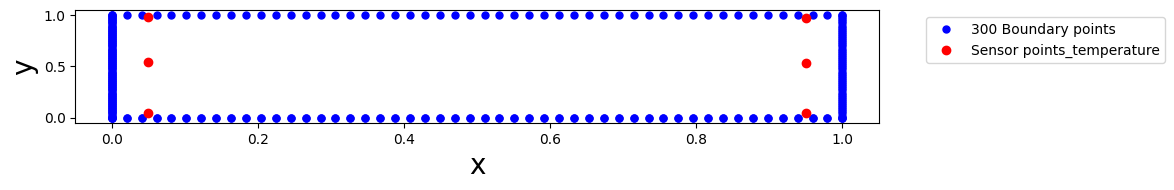

In [101]:
# Plot the locations of boundary and sensor data points

fig,ax = plt.subplots()

# Plot the locations of boundary condition points 
plt.plot(X_train_BC[:,0], X_train_BC[:,1], 'o', color = 'blue', markersize = 5, label = '300 Boundary points')

# Plot the locations of inner domain collocation points (if you want to see change the color)
#plt.plot(X_train_Nf[:,0], X_train_Nf[:,1], 'o', color = 'white',markersize = 3, label = '1000 Latin hypercube collocations')

# Plot the locations of temperature sensor points 
plt.plot(Coordinate_CFD_T[:,0], Coordinate_CFD_T[:,1], '.', color = 'red', markersize = 12, label = 'Sensor points_temperature')

# Plot the locations of pressure sensor points 
#plt.plot(Coordinate_CFD_P[:,0], Coordinate_CFD_P[:,1], '.', color = 'red', markersize = 12, label = '3 Sensor points: velocity, temperature, and pressure')
#plt.plot(Coordinate_CFD_P[:,0], Coordinate_CFD_P[:,1], '.', color = 'purple', markersize = 5, label = 'Sensor points_pressure drop')

plt.rcParams["figure.figsize"] = [12, 2]
plt.rcParams["figure.autolayout"] = True

plt.xlabel('x',size=20)
plt.ylabel('y',size=20)

# plt.title('Total training points',size=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# fig.savefig('Training_points_2D_convection.png', dpi = 500, bbox_inches='tight')

# GPU Setting (Run This ONLY in Our Workstation 2)

In [629]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [630]:
# Store tensors to GPU

# Boundary conditions
X_train_Nu=X_train_BC.float().to(device) # Training Points (BC)
Y_train_Nu=Y_train_BC.float().to(device) # Training Points (BC)

x_BC_lower_T= lower_bound_y.float().to(device)
y_BC_lower_T= lower_bound_T.float().to(device)

x_BC_lower_u= lower_bound_y.float().to(device)
y_BC_lower_u= lower_bound_U.float().to(device)

x_BC_upper_u= upper_bound_y.float().to(device)
y_BC_upper_u= upper_bound_U.float().to(device)

# x_BC_inlet_u= inlet_bound_y.float().to(device)
# y_BC_inlet_u= inlet_bound_U.float().to(device)

x_BC_inlet_p= inlet_bound_y.float().to(device)
y_BC_inlet_p= inlet_bound_p.float().to(device)

# x_BC_inlet_v= inlet_bound_y.float().to(device)
# y_BC_inlet_v= inlet_bound_V.float().to(device)

x_BC_inlet_T= inlet_bound_y.float().to(device)
y_BC_inlet_T= inlet_bound_T.float().to(device)

x_BC_outlet_p= outlet_bound_y.float().to(device)
y_BC_outlet_p= outlet_bound_p.float().to(device)

# Sensor data
X_train_CFD_T=X_train_CFD_T.float().to(device) # Training Points (CFD)
Y_train_CFD_T=Y_train_CFD_T.float().to(device) # Training Points (CFD)

X_train_CFD_U=X_train_CFD_U.float().to(device) # Training Points (CFD)
Y_train_CFD_U=Y_train_CFD_U.float().to(device) # Training Points (CFD)

X_train_CFD_V=X_train_CFD_V.float().to(device) # Training Points (CFD)
Y_train_CFD_V=Y_train_CFD_V.float().to(device) # Training Points (CFD)

X_train_CFD_P=X_train_CFD_P.float().to(device) # Training Points (CFD)
Y_train_CFD_P=Y_train_CFD_P.float().to(device) # Training Points (CFD)

# Inner domain collocation points
X_train_Nf=X_train_Nf.float().to(device) # Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device) # To minimize function

X_plot=x_plot.float().to(device) # the input dataset (complete)
# Y_test=y_test.float().to(device) # the real solution 

# Define Neural Network and Loss Functions

In [3]:
class FCN(nn.Module):

    ## Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) # Neural Network
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
                        
        'foward pass'     
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)               
            a = self.activation(z)    
        a = self.linears[-1](a)            # Neural network feedforard output
        return a
      
    ## Boundary condition losses

    # Temperature at x = 0
    def lossBC_inletT(self,x_BC_inlet_T,y_BC_inlet_T):
        
        predict = self.forward(x_BC_inlet_T)
        input_inlet_T=predict[:,2]
        input_inlet_T=input_inlet_T.unsqueeze(1) 
        loss_BC_inlet_T=self.loss_function(input_inlet_T,y_BC_inlet_T)
        
        return loss_BC_inlet_T
    
    # Temperature at y = 0
    def lossBC_lowerT(self,x_BC_lower_T,y_BC_lower_T):
        
        predict = self.forward(x_BC_lower_T)
        input_lower_T=predict[:,2]
        input_lower_T=input_lower_T.unsqueeze(1) 
        loss_BC_lower_T=self.loss_function(input_lower_T,y_BC_lower_T)
        
        return loss_BC_lower_T  
       
    # u-velocity at x = 0    
    def lossBC_inletu(self,x_BC_inlet_u,y_BC_inlet_u): 
        
        input_inlet_u=self.forward(x_BC_inlet_u)[:,0]
        input_inlet_u=input_inlet_u.unsqueeze(1) 
        loss_BC_inlet_u=self.loss_function(input_inlet_u,y_BC_inlet_u)
        
        return loss_BC_inlet_u
    
    # u-velocity at y = 0
    def lossBC_loweru(self,x_BC_lower_u,y_BC_lower_u): 
        
        input_lower_u=self.forward(x_BC_lower_u)[:,0]
        input_lower_u=input_lower_u.unsqueeze(1) 
        loss_BC_lower_u=self.loss_function(input_lower_u,y_BC_lower_u)
        
        return loss_BC_lower_u
    
    # u-velocity at y = 1
    def lossBC_upperu(self,x_BC_upper_u,y_BC_upper_u):
        
        input_upper_u=self.forward(x_BC_upper_u)[:,0]
        input_upper_u=input_upper_u.unsqueeze(1) 
        loss_BC_upper_u=self.loss_function(input_upper_u,y_BC_upper_u)
        
        return loss_BC_upper_u
    
    # v-velocity at x = 0
# #     def lossBC_inletv(self,x_BC_inlet_v,y_BC_inlet_v): 
        
# #         input_inlet_v=self.forward(x_BC_inlet_v)[:,1]
# #         input_inlet_v=input_inlet_v.unsqueeze(1) 
# #         loss_BC_inlet_v=self.loss_function(input_inlet_v,y_BC_inlet_v)
        
#         return loss_BC_inlet_u

    # Pressure at x = 0
    def lossBC_inletp(self,x_BC_inlet_p,y_BC_inlet_p):
        
        input_inlet_p=self.forward(x_BC_inlet_p)[:,1]
        input_inlet_p= input_inlet_p.unsqueeze(1) 
        loss_BC_inlet_p=self.loss_function(input_inlet_p,y_BC_inlet_p)
        
        return loss_BC_inlet_p    

    # Pressure at x = 1
    def lossBC_outletp(self,x_BC_outlet_p,y_BC_outlet_p):
        
        input_outlet_p=self.forward(x_BC_outlet_p)[:,1]
        input_outlet_p= input_outlet_p.unsqueeze(1) 
        loss_BC_outlet_p=self.loss_function(input_outlet_p,y_BC_outlet_p)
        
        return loss_BC_outlet_p
 
    
    ## Sensor data losses
    
    # Temperature data
    def lossCFD_T(self,X_train_CFD_T,Y_train_CFD_T):
        
        input_CFD_T=self.forward(X_train_CFD_T)[:,2]
        input_CFD_T=input_CFD_T.unsqueeze(1) 
        loss_CFD_T=self.loss_function(input_CFD_T,Y_train_CFD_T)
        
        return loss_CFD_T
    
    # u-velocity data
    def lossCFD_U(self, X_train_CFD_U,Y_train_CFD_U):
        
        input_CFD_U=self.forward(X_train_CFD_U)[:,0]
        input_CFD_U=input_CFD_U.unsqueeze(1)
        loss_CFD_U=self.loss_function(input_CFD_U,Y_train_CFD_U)
        
        return loss_CFD_U
    
    # v-velocity data
#     def lossCFD_V(self, X_train_CFD_V,Y_train_CFD_V):
        
#         input_CFD_V=self.forward( X_train_CFD_V)[:,1]
#         input_CFD_V=input_CFD_V.unsqueeze(1)
#         loss_CFD_V=self.loss_function(input_CFD_V,Y_train_CFD_V)
        
#         return loss_CFD_V
    
    # Pressure data
    def lossCFD_P(self,X_train_CFD_P,Y_train_CFD_P):
        
        input_CFD_P=self.forward(X_train_CFD_P)[:,1]
        input_CFD_P=input_CFD_P.unsqueeze(1)
        loss_CFD_P=self.loss_function(input_CFD_P,Y_train_CFD_P)
        
        return loss_CFD_P
    
    ## Inner collocation datapoints losses (PDE losses)
    
    # Mass conservation
    def lossPDE_continuity(self,x_PDE):
        
        g=x_PDE.clone()
        g.requires_grad=True # Enable differentiation
        forward_output = self.forward(g)

        u=forward_output[:,0]
        u=u.unsqueeze(1)     # Converting 1D to 2D tensor ([1200] vs [1200,1])
        
#         v=forward_output[:,1]
#         v=v.unsqueeze(1)

        # Computes the sum of gradients of outputs with respect to the inputs
        # autograd.grad(outputs,inputs)
        u_x_y = autograd.grad(u,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative    
#         v_x_y = autograd.grad(v,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      
      ### LESLIE: As each u_x_y, u_xx_yy are single values (i.e. X not [X, Y, ...]), you can't access using multiple indices
        
        u_x=u_x_y[:,[0]]     # Select the 1st element for x-derivative (Remember input X=[x,y]) 
        u_y=u_x_y[:,[1]]     # Select the 2nd element for y-derivative (Remember input X=[x,y]) 
    
#         v_x=v_x_y[:,[0]]
#         v_y=v_x_y[:,[1]]
        
        #loss_continuity = u_x - v_y
        loss_continuity =  u_x
        
        return self.loss_function(loss_continuity,f_hat)

    # x-momentum conservation
    def lossPDE_x_momentum(self,x_PDE,Re):
        
        g=x_PDE.clone()
        g.requires_grad=True # Enable differentiation
        forward_output = self.forward(g)

        u=forward_output[:,0]
        u=u.unsqueeze(1)         # converting 1D to 2D tensor ([1200] vs [1200,1])
        
#         v=forward_output[:,1]
#         v=v.unsqueeze(0)
#         v=torch.transpose(v,0,1)
    
        p=forward_output[:,1]
        p=p.unsqueeze(1)

        # Computes the sum of gradients of outputs with respect to the inputs
        u_x_y = autograd.grad(u,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(g.shape).to(device), create_graph=True)[0] #second derivative
    
#         v_x_y = autograd.grad(v,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
#         v_xx_yy = autograd.grad(v_x_y,g,torch.ones(g.shape).to(device), create_graph=True)[0] #second derivative
    
        p_x_y = autograd.grad(p,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
        p_xx_yy = autograd.grad(p_x_y,g,torch.ones(g.shape).to(device), create_graph=True)[0] #second derivative
        
        u_x=u_x_y[:,[0]] # Select the 1st element for x-derivative (Remember input X=[x,y]) 
        u_y=u_x_y[:,[1]] # Select the 2nd element for y-derivative (Remember input X=[x,y]) 
        u_xx=u_xx_yy[:,[0]] 
        u_yy=u_xx_yy[:,[1]] 
    
#         v_x=v_x_y[:,[0]] 
#         v_y=v_x_y[:,[1]]
#         v_xx=v_xx_yy[:,[0]] 
#         v_yy=v_xx_yy[:,[1]]
    
        p_x=p_x_y[:,[0]] 
        p_y=p_x_y[:,[1]]
        p_xx=p_xx_yy[:,[0]] 
        p_yy=p_xx_yy[:,[1]]
      
        loss_x_momentum = u*u_x + p_x-((1/Re)*(u_xx+u_yy))
                
        return  self.loss_function(loss_x_momentum,f_hat)
    
    # y-momentum conservation
    def lossPDE_y_momentum(self,x_PDE,Re):
        
        g=x_PDE.clone()
        g.requires_grad=True #Enable differentiation
        forward_output = self.forward(g)
        
        u=forward_output[:,0]
        u=u.unsqueeze(1)         # converting 1D to 2D tensor ([1200] vs [1200,1])
        
#         v=forward_output[:,1]
#         v=v.unsqueeze(0)
#         v=torch.transpose(v,0,1)
    
        p=forward_output[:,1]
        p=p.unsqueeze(1)
        
        # Computes the sum of gradients of outputs with respect to the inputs
        u_x_y = autograd.grad(u,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(g.shape).to(device), create_graph=True)[0] #second derivative
    
#         v_x_y = autograd.grad(v,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
#         v_xx_yy = autograd.grad(v_x_y,g,torch.ones(g.shape).to(device), create_graph=True)[0] #second derivative
    
        p_x_y = autograd.grad(p,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
        p_xx_yy = autograd.grad(p_x_y,g,torch.ones(g.shape).to(device), create_graph=True)[0] #second derivative
        
        u_x=u_x_y[:,[0]] # Select the 1st element for x-derivative (Remember input X=[x,y]) 
        u_y=u_x_y[:,[1]] # Select the 2nd element for y-derivative (Remember input X=[x,y]) 
        u_xx=u_xx_yy[:,[0]]
        u_yy=u_xx_yy[:,[1]]
    
#         v_x=v_x_y[:,[0]] 
#         v_y=v_x_y[:,[1]]
#         v_xx=v_xx_yy[:,[0]] 
#         v_yy=v_xx_yy[:,[1]]
    
        p_x=p_x_y[:,[0]] 
        p_y=p_x_y[:,[1]]
        p_xx=p_xx_yy[:,[0]] 
        p_yy=p_xx_yy[:,[1]]
        
#         loss_y_momentum = u*v_x + v*v_y + p_y-((1/Re)*(v_xx+v_yy))
        loss_y_momentum =  p_y
        
        return  self.loss_function(loss_y_momentum,f_hat)
    
    # Energy conservation
    def lossPDE_energy(self,x_PDE,Pe):
        
        g=x_PDE.clone()
        g.requires_grad=True #Enable differentiation
        forward_output = self.forward(g)
        
        u=forward_output[:,0]
        u=u.unsqueeze(1)         # converting 1D to 2D tensor ([1200] vs [1200,1])

#         v=forward_output[:,1]
#         v=v.unsqueeze(0)
#         v=torch.transpose(v,0,1)
    
        T=forward_output[:,2]
        T=T.unsqueeze(0)
        T=torch.transpose(T,0,1)
    
        # Computes the sum of gradients of outputs with respect to the inputs
        T_x_y = autograd.grad(T,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
        T_xx_yy = autograd.grad(T_x_y,g,torch.ones(g.shape).to(device), create_graph=True)[0] #second derivative
    
        T_x=T_x_y[:,[0]] # Select the 1st element for x-derivative (Remember input X=[x,y]) 
        T_y=T_x_y[:,[1]] # Select the 2nd element for y-derivative (Remember input X=[x,y]) 
        T_xx=T_xx_yy[:,[0]] 
        T_yy=T_xx_yy[:,[1]]
        
        loss_energy = u*T_x - (1/Pe)*(T_xx +T_yy)
        
        return  self.loss_function(loss_energy,f_hat)                 
    
    #LGFBS                 
    #def closure(self):
        #optimizer.zero_grad()  
        #loss = self.loss(x_BC_lower_T,y_BC_lower_T,x_BC_inlet_u,y_BC_inlet_u,x_BC_inlet_T,y_BC_inlet_T,
                         #x_BC_outlet_p,y_BC_outlet_p,X_train_CFD_T,Y_train_CFD_T,X_train_CFD_U,Y_train_CFD_U,x_CFD_P,y_CFD_P,X_train_Nf)
#         loss.backward()      
#         self.iter += 1
#         if self.iter % 100 == 0:
            
#             print("Training Error:",loss.detach().cpu().numpy())
#         return loss

# Generate PINN

In [ ]:
PINN = FCN(layers)
PINN.to(device)
print(PINN)

params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)

# Train PINN

In [ ]:
# Define arrays to store losses over epochs

# Total loss
l = np.zeros(epochs)

# PDE losses
l_pde_continuity = np.zeros(epochs)
l_pde_x_momentum = np.zeros(epochs)
l_pde_y_momentum = np.zeros(epochs)
l_pde_energy = np.zeros(epochs)

# Boundary condition losses
l_bc_inlet_T = np.zeros(epochs)
l_bc_lower_T = np.zeros(epochs)
# l_bc_inlet_u = np.zeros(epochs)
l_bc_inlet_p = np.zeros(epochs)
# l_bc_inlet_v = np.zeros(epochs)
l_bc_lower_u = np.zeros(epochs)
l_bc_upper_u = np.zeros(epochs)
l_bc_outlet_p = np.zeros(epochs)

# Sensor data losses
l_cfd_T = np.zeros(epochs)
l_cfd_u = np.zeros(epochs)
# l_cfd_v = np.zeros(epochs)
l_cfd_p = np.zeros(epochs)

# Training loop
for i in range(epochs):
    
#     loss = PINN.loss(x_BC_lower_T,y_BC_lower_T,x_BC_inlet_u,y_BC_inlet_u,x_BC_inlet_T,y_BC_inlet_T,
#                      x_BC_outlet_p,y_BC_outlet_p,x_BC_lower_u,y_BC_lower_u,x_BC_upper_u,y_BC_upper_u,
#                      X_train_CFD_T,Y_train_CFD_T,X_train_CFD_U,Y_train_CFD_U,X_train_CFD_V,Y_train_CFD_V,
#                      X_train_CFD_P,Y_train_CFD_P,X_train_Nf)
        
#     loss_pde=PINN.lossPDE(X_train_Nf)

    ## Loss calculations
    # PDE losses
    loss_con = PINN.lossPDE_continuity(X_train_Nf)
    loss_mom_x = PINN.lossPDE_x_momentum(X_train_Nf,Re)
    loss_mom_y = PINN.lossPDE_y_momentum(X_train_Nf,Re)
    loss_ene = PINN.lossPDE_energy(X_train_Nf,Pe)
    
    # Boundary condition losses
    lossBC_inlet_T = PINN.lossBC_inletT(x_BC_inlet_T,y_BC_inlet_T)
    lossBC_lower_T = PINN.lossBC_lowerT(x_BC_lower_T,y_BC_lower_T)
#     lossBC_inlet_u = PINN.lossBC_inletu(x_BC_inlet_u,y_BC_inlet_u)
    lossBC_upper_u = PINN.lossBC_upperu(x_BC_upper_u,y_BC_upper_u)
    lossBC_lower_u = PINN.lossBC_loweru(x_BC_lower_u,y_BC_lower_u)
#     lossBC_inlet_v = PINN.lossBC_inletu(x_BC_inlet_v,y_BC_inlet_v)
    lossBC_inlet_p = PINN.lossBC_inletp(x_BC_inlet_p,y_BC_inlet_p)
    lossBC_outlet_p = PINN.lossBC_outletp(x_BC_outlet_p,y_BC_outlet_p)
    
    # Sensor data losses
    loss_CFD_T=PINN.lossCFD_T(X_train_CFD_T,Y_train_CFD_T)
    loss_CFD_U=PINN.lossCFD_U(X_train_CFD_U,Y_train_CFD_U)
#     loss_CFD_V=PINN.lossCFD_V(X_train_CFD_V,Y_train_CFD_V)
    loss_CFD_P=PINN.lossCFD_P(X_train_CFD_P,Y_train_CFD_P)
       
    # Total loss
    loss =(lossBC_inlet_T+lossBC_lower_T+lossBC_upper_u+lossBC_lower_u+lossBC_outlet_p+lossBC_inlet_p
           +loss_con+loss_mom_x+ loss_mom_y+loss_ene+loss_CFD_U+loss_CFD_T+loss_CFD_P)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Saving the losses
    l[i] = loss

    l_bc_inlet_T[i] = lossBC_inlet_T
    l_bc_lower_T[i] = lossBC_lower_T
#     l_bc_inlet_u[i] = lossBC_inlet_u
#     l_bc_inlet_v[i] = lossBC_inlet_v
    l_bc_lower_u[i] = lossBC_upper_u
    l_bc_upper_u[i] =  lossBC_lower_u
    l_bc_inlet_p[i] =  lossBC_inlet_p
    l_bc_outlet_p[i] =  lossBC_outlet_p
    
    l_cfd_T[i] = loss_CFD_T
    l_cfd_u[i] = loss_CFD_U
#     l_cfd_v[i] = loss_CFD_V
    l_cfd_p[i] = loss_CFD_P
    
    l_pde_continuity[i] = loss_con
    l_pde_x_momentum[i] = loss_mom_x
    l_pde_y_momentum[i] = loss_mom_y
    l_pde_energy[i] = loss_ene

    # print("training loss:", loss)

In [17]:
# Save the trainned model to disk
torch.save(PINN.state_dict(),filename)

# Loss Plots

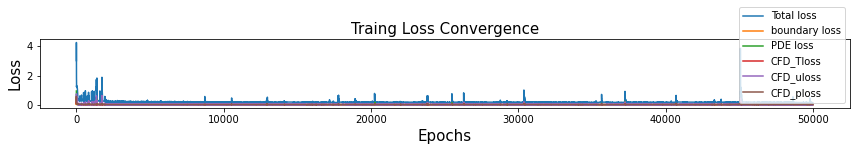

In [825]:
iteration = np.linspace(0,epochs,epochs)

# Total loss
plt.plot(iteration,l)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

# Boundary condition losses
plt.plot(iteration,l_bc_inlet_T)
plt.plot(iteration,l_bc_lower_T)

# Sensor data losses
plt.plot(iteration, l_cfd_T)
plt.plot(iteration, l_cfd_u)
# plt.plot(iteration, l_cfd_v)
plt.plot(iteration,l_cfd_p)

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("Loss",size=15)
plt.legend(['Total loss','boundary loss', 'PDE loss','CFD_Tloss','CFD_uloss','CFD_ploss'])

plt.show()

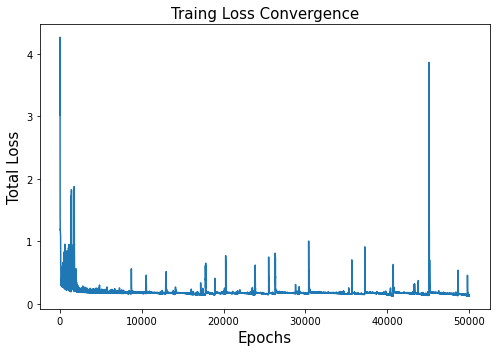

In [826]:
# Total loss
plt.plot(iteration,l)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("Total Loss",size=15)

plt.show()

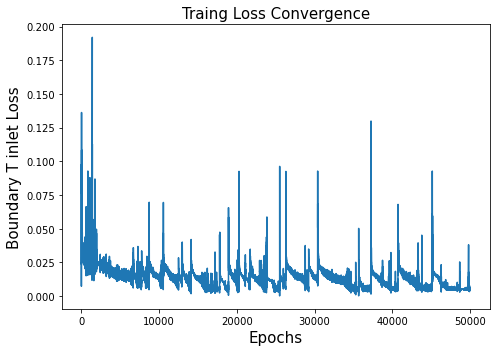

In [827]:
# Inlet temperature boundary condition loss
plt.plot(iteration, l_bc_inlet_T)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("Boundary T inlet Loss",size=15)


plt.show()

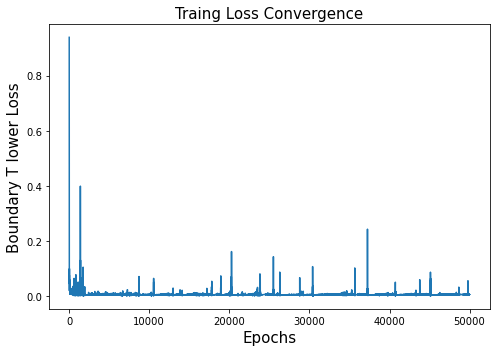

In [828]:
# Heated wall temperature boundary condition loss
plt.plot(iteration, l_bc_lower_T)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("Boundary T lower Loss",size=15)


plt.show()

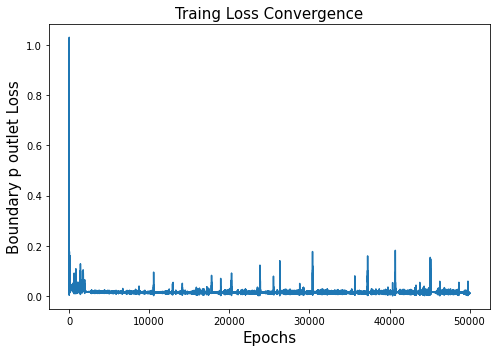

In [829]:
# Outlet pressure boundary condition loss
plt.plot(iteration, l_bc_outlet_p)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("Boundary p outlet Loss",size=15)


plt.show()

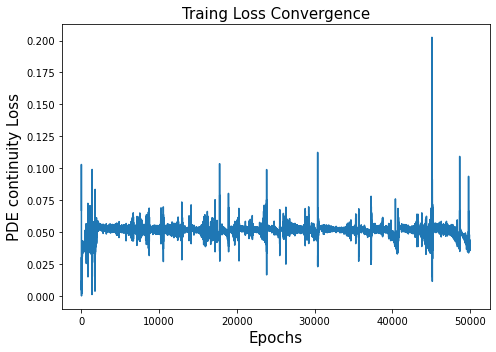

In [830]:
# Mass conservation loss
plt.plot(iteration,l_pde_continuity)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("PDE continuity Loss",size=15)


plt.show()

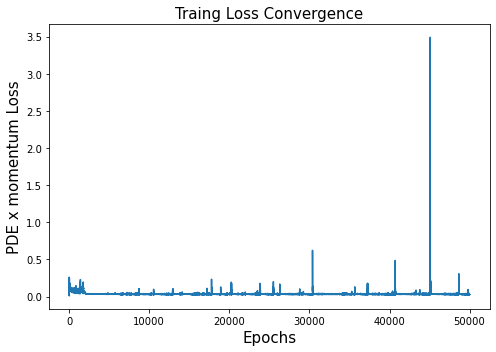

In [831]:
# x-momentum conservation loss
plt.plot(iteration,l_pde_x_momentum)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("PDE x momentum Loss",size=15)

plt.show()

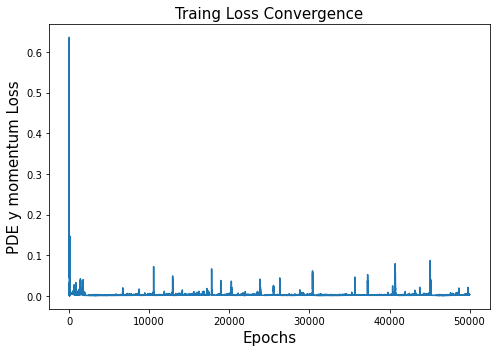

In [832]:
# y-momentum conservation loss
plt.plot(iteration,l_pde_y_momentum)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("PDE y momentum Loss",size=15)

plt.show()

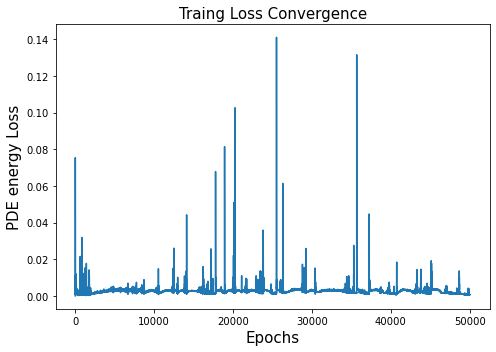

In [833]:
# Energy conservation loss
plt.plot(iteration,l_pde_energy)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("PDE energy Loss",size=15)

plt.show()

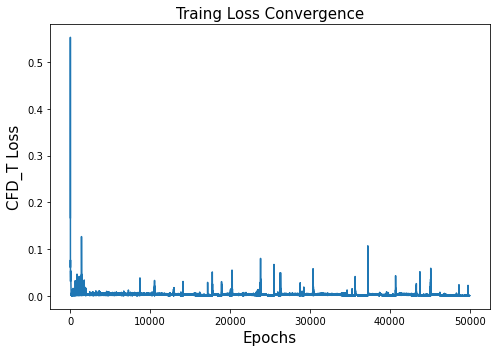

In [834]:
# Temperature sensor data loss
plt.plot(iteration, l_cfd_T)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("CFD_T Loss",size=15)

plt.show()

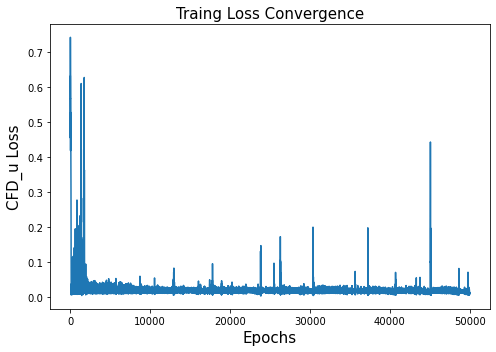

In [835]:
# u-velocity sensor data loss
plt.plot(iteration,l_cfd_u)

plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("CFD_u Loss",size=15)

plt.show()

In [836]:
# v-velocity sensor data loss
# plt.plot(iteration,l_cfd_v)

# plt.rcParams["figure.figsize"] =  [7, 5]
# plt.rcParams["figure.autolayout"] = True

# plt.title("Traing Loss Convergence",size=15)
# plt.xlabel("Epochs",size=15)
# plt.ylabel("CFD_v Loss",size=15)

# plt.show()

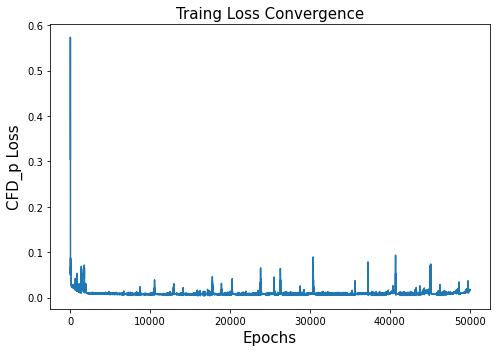

In [837]:
# Pressure sensor data loss
plt.plot(iteration,l_cfd_p)
plt.rcParams["figure.figsize"] =  [7, 5]
plt.rcParams["figure.autolayout"] = True

plt.title("Traing Loss Convergence",size=15)
plt.xlabel("Epochs",size=15)
plt.ylabel("CFD_p Loss",size=15)

plt.show()

# Visualization

In [838]:
y_predict_T_plot=PINN(X_plot)[:,2] # Collect temperature T

y_predict_u_plot=PINN(X_plot)[:,0] # Collect velocity u

# y_predict_v=PINN(X_test)[:,1] # Collect velocity v

y_predict_p_plot=PINN(X_plot)[:,1] # Collect pressure P

x=X_plot[:,0]
y=X_plot[:,1]

X=x.reshape(shape=[50,50]).transpose(1,0).detach().cpu()
Y=y.reshape(shape=[50,50]).transpose(1,0).detach().cpu()

Y_predict_T_plot=y_predict_T_plot.reshape(shape=[50,50]).transpose(1,0).detach().cpu()

Y_predict_u_plot=y_predict_u_plot.reshape(shape=[50,50]).transpose(1,0).detach().cpu()

Y_predict_p_plot=y_predict_p_plot.reshape(shape=[50,50]).transpose(1,0).detach().cpu()

In [839]:
def plot3D_Matrix_T(t,x,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)

  plt.rcParams["figure.figsize"] = [12, 2]
  plt.rcParams["figure.autolayout"] = True

  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")

  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('T')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  plt.show()

In [840]:
def plot3D_Matrix_u(t,x,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  plt.rcParams["figure.figsize"] = [12, 2]
  plt.rcParams["figure.autolayout"] = True
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('u')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  plt.show()

In [841]:
def plot3D_Matrix_v(t,x,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  plt.rcParams["figure.figsize"] =  [12, 2]
  plt.rcParams["figure.autolayout"] = True
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('v')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  plt.show()

In [842]:
def plot3D_Matrix_p(t,x,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  plt.rcParams["figure.figsize"] =  [12, 2]
  plt.rcParams["figure.autolayout"] = True
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('P')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  plt.show()

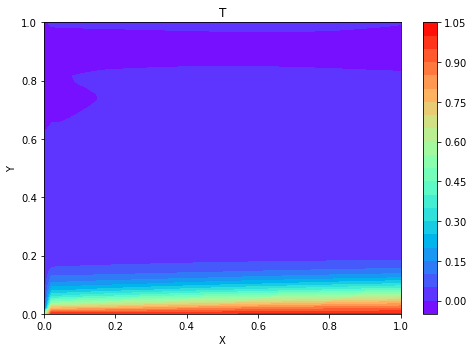

In [843]:
plot3D_Matrix_T(X,Y,Y_predict_T_plot)

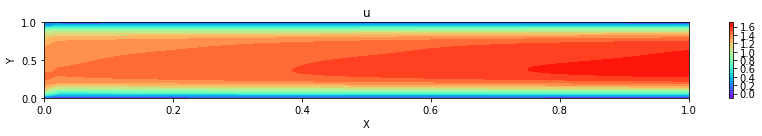

In [844]:
plot3D_Matrix_u(X,Y,Y_predict_u_plot)

In [845]:
# plot3D_Matrix_v(X,Y,Y_predict_v)

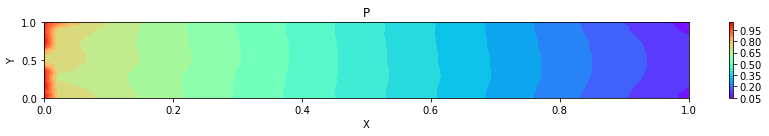

In [846]:
plot3D_Matrix_p(X,Y,Y_predict_p_plot)

In [848]:
y_predict_T=PINN(x_test_groundtruth)[:,2] # Collect temperature T
y_predict_T=y_predict_T.unsqueeze(0)        
y_predict_T=torch.transpose(y_predict_T,0,1)

y_predict_T = y_predict_T.detach().numpy()

print(T_groundtruth.shape)
print(y_predict_T.shape)


(1500, 1)
(1500, 1)


In [849]:
y_predict_u=PINN(x_test_groundtruth)[:,0] # Collect velocity u
y_predict_u=y_predict_u.unsqueeze(0)        
y_predict_u=torch.transpose(y_predict_u,0,1)
y_predict_u = y_predict_u.detach().numpy()
print(u_groundtruth.shape)
print(y_predict_u.shape)


(1500, 1)
(1500, 1)


In [850]:
y_predict_p=PINN(x_test_groundtruth)[:,1] # Collect pressure P
y_predict_p=y_predict_p.unsqueeze(0)        
y_predict_p=torch.transpose(y_predict_p,0,1)
y_predict_P = y_predict_p.detach().numpy()
print(u_groundtruth.shape)
print(y_predict_u.shape)
print(x_test_groundtruth)


(1500, 1)
(1500, 1)
tensor([[1.0000, 0.0900],
        [0.9900, 0.0700],
        [1.0000, 0.0400],
        ...,
        [0.0000, 0.9800],
        [0.0100, 0.9800],
        [0.0100, 1.0000]], dtype=torch.float64)


In [851]:
Error_T = metrics.r2_score(T_groundtruth,y_predict_T)
print("R square error of T", Error_T )

R square error of T 0.9589956404110722


In [852]:
Error_u = metrics.r2_score(u_groundtruth,y_predict_u)
print("R square error of u", Error_u )

R square error of u 0.7938733924841112


In [853]:
Error_P = metrics.r2_score(P_groundtruth,y_predict_P)
print("R square error of P", Error_P )

R square error of P 0.8975254561139874
